In [1]:
# Učitaj osnovne biblioteke...
import scipy as sp
import sklearn
import itertools
import cv2
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
bgr_image = cv2.imread('tor_700p.jpg')
gray_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2GRAY)

In [3]:
#cv2.imshow('image',image)

In [4]:
scan_line = gray_image[len(gray_image)*2/3,:]

In [328]:
from scipy import ndimage

def symmetry_factor(scan_line, index, max_width):
    left = scan_line[index-max_width:index].astype(float)
    right = np.flipud(scan_line[index:index+max_width]).astype(float)
    #left = np.ones(len(left))*255
    #right = np.zeros(len(right))
    diff = np.abs(left - right)
    
    kernel = cv2.getGaussianKernel(len(diff)*2,0)[len(diff):]*2
    return diff.dot(kernel)#np.average(diff) 

def scan_whole_line(whole_image, height_index=400, max_width = 100):
    scan_line = whole_image[height_index,:]
    #print list(scan_line)
    X = range(max_width,len(scan_line)-max_width)
    
    Y=np.array([symmetry_factor(scan_line,index,max_width) for index in X])

    return np.squeeze(Y)
    #res = np.ones(len(scan_line))[:np.newaxis]*128
    #res[max_width:len(scan_line)-max_width] = np.squeeze(Y)
    #return res
    #Y= res
    #Y = ndimage.correlate1d(Y,np.ones(2))

    #c = np.ones(50)
    #c = list(c)+[-len(c)]+list(-c)
    #Y1 = ndimage.correlate1d(Y, c)

    #Y2 = ndimage.correlate1d(Y1, [-1,0,1])

    #indices = np.indices(Y.shape) + max_width

    #Y1_zero =np.abs(Y1) <1
    #Y2_positive = Y2>0
    
    
    #print np.sum(Y1_zero)   
    #print np.sum(Y2_positive)


    #Yminima = np.logical_and(Y1_zero,Y2_positive)


    #Y2 - np.abs(Y1)
    #print np.sum(Yminima)
    
    #print Yminima
    #best_indexes = indices[0][Y<50]

    #print best_indexes.shape
    
    #     results = []
    #     for index in best_indexes:
    #         #if index < max_width or index> len(image)-max_width:
    #         #    continue
    #         results.append((int(index),int(height_index)))
    #         break
    #         drawing = bgr_image.copy()
    #         cv2.line(drawing,(0,height_index),(len(scan_line),height_index),(0,255,255))
    #         cv2.line(drawing,(index,0),(index,len(image)),(0,0,255))
    #         cv2.line(drawing,(index-max_width,0),(index-max_width,len(image)),(255,0,0))
    #         cv2.line(drawing,(index+max_width,0),(index+max_width,len(image)),(255,0,0))
    #         cv2.imshow("jej",drawing)
    #         c = cv2.waitKey(0)
    #         if 'q' == chr(c & 255):
    #             break
    #     return Y

    #     plt.figure(figsize=(20,20))
    #     d = drawing.copy()
    #     cv2.line(d,(0,height_index),(len(scan_line),height_index),(0,255,255))
    #     plt.subplot(2,1,1),plt.imshow(d)
    #     plt.subplot(2,1,2),plt.axis([0,700,0,np.log(2000000)]),  plt.scatter(X,np.log(Y))
    #     plt.show()

    # plt.show()
    # plt.scatter(X,Y1)
    # plt.show()
    # plt.scatter(X,Y2)
    # plt.show()
    #plt.scatter(best_indexes,np.ones(best_indexes.shape))
    #plt.show()
    #     return results

    #print best_indexes

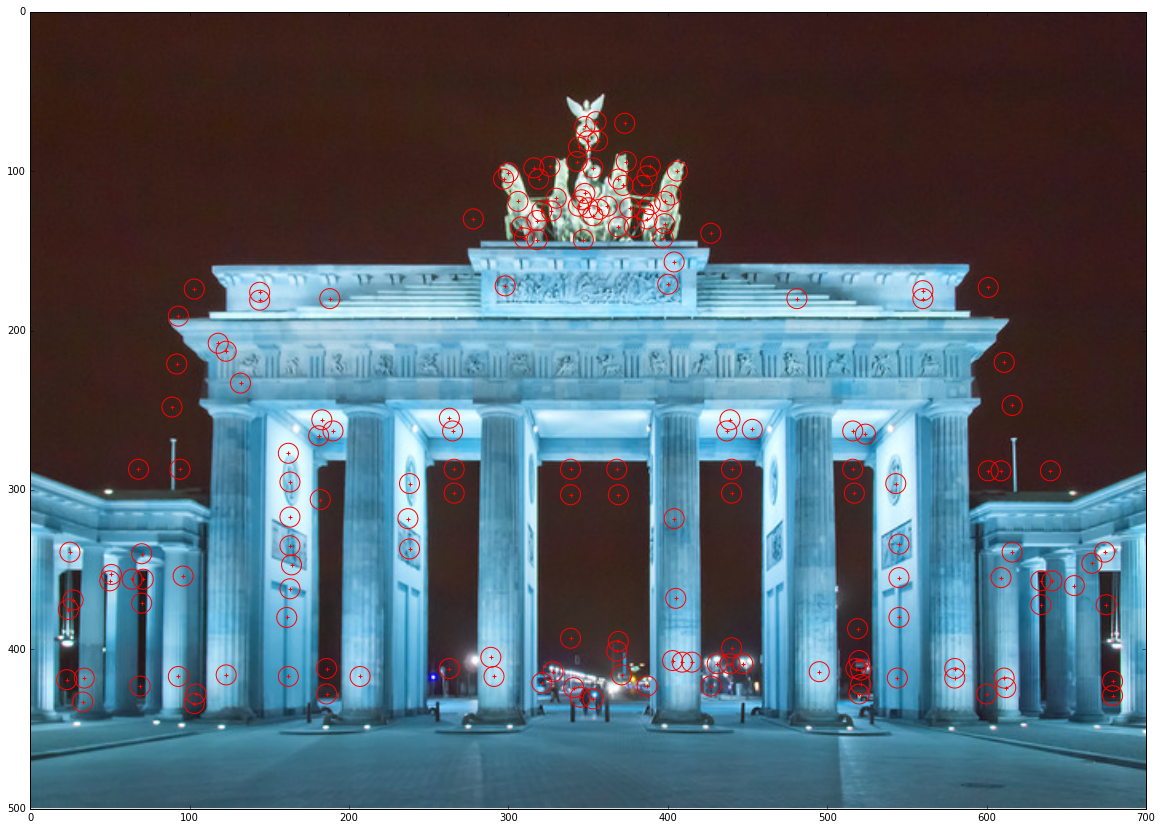

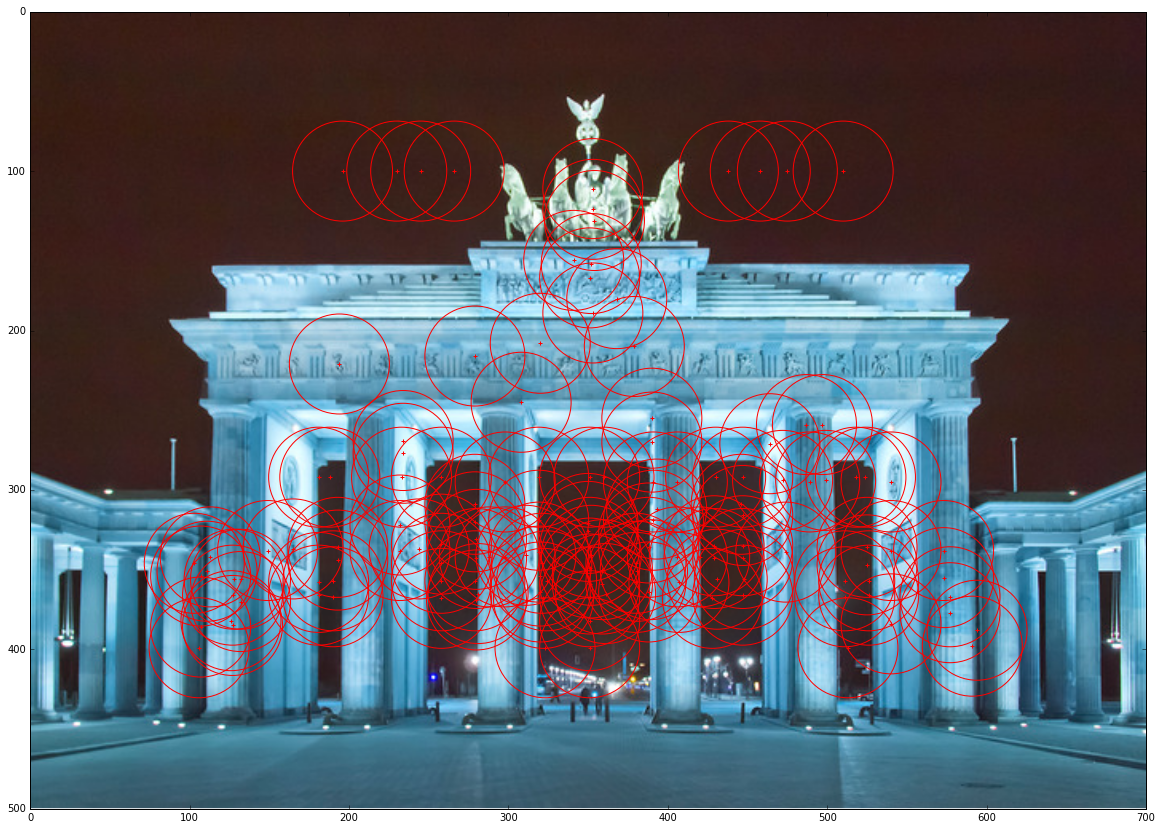

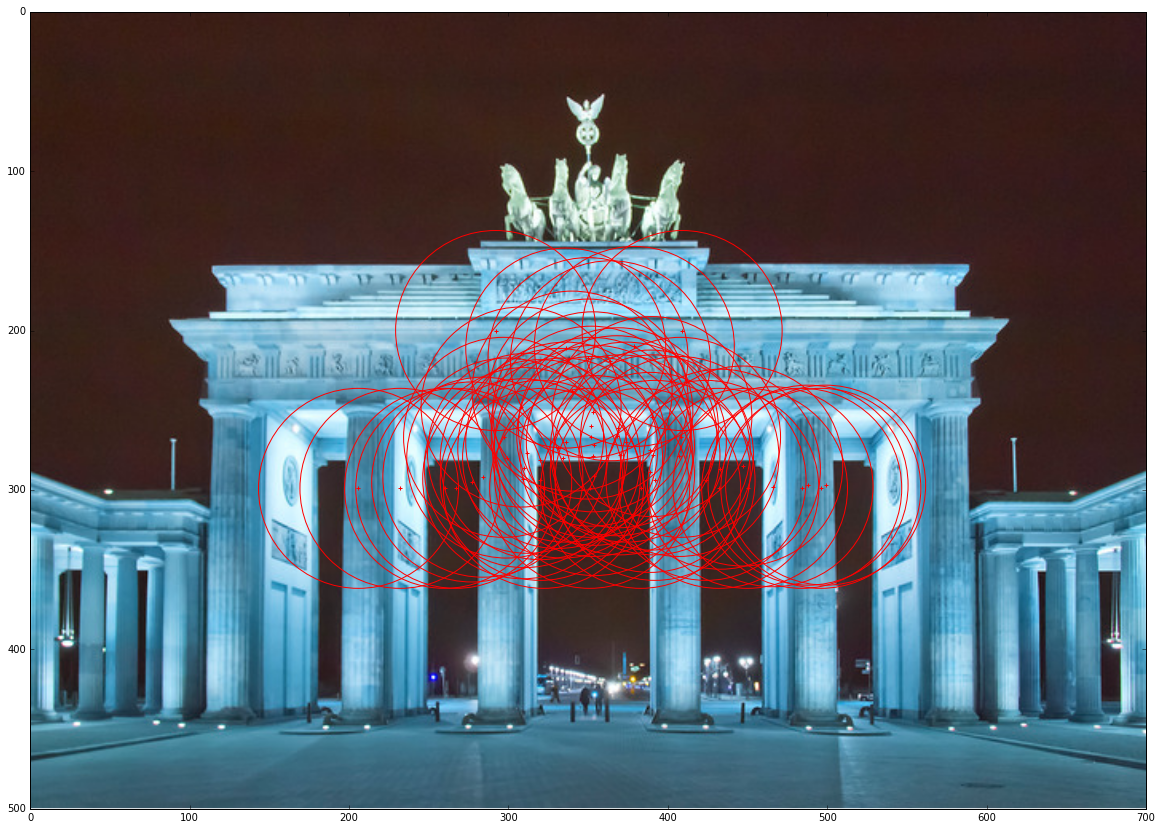

In [376]:
processed_image = gray_image.copy()
#processed_image = cv2.GaussianBlur(processed_image,sigmaX=0,ksize=(5,5)) 
#processed_image = cv2.Laplacian(processed_image,cv2.CV_64F,ksize=5)
#plt.imshow(processed_image,cmap = 'gray')
drawing = bgr_image.copy()

#print processed_image[20:40,20:40]
def create_symmetry_map(image,width):
    img = np.zeros(image.shape[1] - width*2)
    for num in xrange(1,image.shape[0]):
        results = scan_whole_line(image,num,width)
        img = np.vstack((img,results))
    img = img.astype(np.float32)
    kernel_size= 7
    img = cv2.GaussianBlur(img,sigmaX=0,ksize=(kernel_size,1)) 
    img = cv2.Sobel(img,cv2.CV_32F,2,0,ksize=kernel_size)
    padding = np.zeros((img.shape[0],width))
    
    return np.hstack((padding,img,padding))#[:,w:img.shape[1]-w]

import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters


for w in [20,100,200]:#linspace(25,350,20):
    processed_map_horizontal = create_symmetry_map(processed_image,w)
        
    processed_map_vertical = create_symmetry_map(processed_image.transpose(),w).T
    
    processed_map_horizontal[processed_map_horizontal<0]=0
    processed_map_vertical[processed_map_vertical<0] = 0
    processed_map = processed_map_horizontal*processed_map_vertical
    #mapa = cv2.convertScaleAbs(img)
    #img= -img
    
    #processed_map[processed_map<0] = 0
    
    #print np.max(processed_map)
    #print np.min(processed_map)
    processed_map = processed_map.astype(np.float32)
    processed_map[processed_map<np.max(processed_map)*0.1] = 0
    
    neighborhood_size = 5
    threshold = 0

    data = processed_map

    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

    #_,processed_map =cv2.threshold(processed_map,np.max(processed_map)*0.5,1,cv2.THRESH_BINARY)
    plt.figure(figsize=(20,20))
    #cv2.imshow("s",processed_map)
    #plt.imshow(processed_map_horizontal,cmap='gray')
    #plt.show()
    #plt.figure(figsize=(20,20))
    #plt.imshow(processed_map_vertical,cmap='gray')
    #plt.show()
    plt.figure(figsize=(20,20))
    plt.imshow(bgr_image)
    
    plt.axis([0,bgr_image.shape[1],bgr_image.shape[0],0])
    #plt.scatter(xy[:, 1], xy[:, 0], '')
    plt.scatter(xy[:, 1], xy[:, 0],s = w*w,facecolors='none', edgecolors='r')
    plt.scatter(xy[:, 1], xy[:, 0],marker='+',c='r')
    plt.show()

    #plt.imshow(processed_map,cmap='gray')    
    #plt.show()


        #for r in results:
        #    cv2.circle(drawing,r,int(w),(255,255,255))
        #cv2.imshow("stream",drawing)

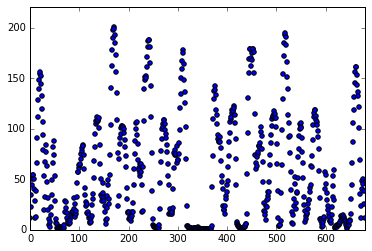

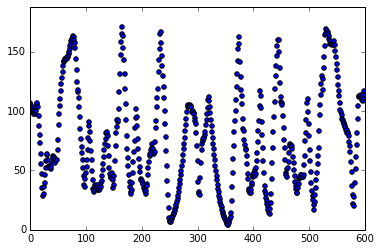

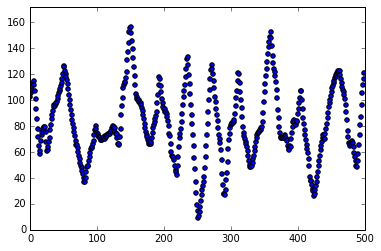

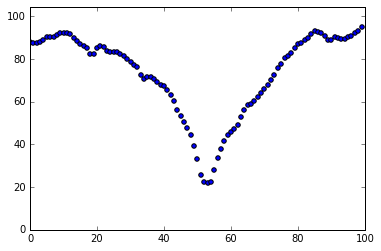

In [191]:
processed_image = gray_image.copy()
for x in [10,50,100,300]:
    results = scan_whole_line(processed_image,300,x)
    plt.axis([0,len(results),0,np.max(results)*1.1])
    plt.scatter(range(len(results)),results)
    plt.show()

In [192]:
diff = np.ones((2,1))
diff *=diff
kernel = cv2.getGaussianKernel(len(diff),0)
print kernel
print np.sum(kernel * diff)#np.average(diff) 

[[ 0.5]
 [ 0.5]]
1.0


In [193]:
N=20
D=3000

sampleInput = cv2.getGaussianKernel(N*2,0)[:N].T*2*D
print sampleInput

left = list(sampleInput[0])#np.ones(N)*D
right = np.zeros(N)
diff = np.abs(left - right)
kernel = cv2.getGaussianKernel(len(diff)*2,0)[len(diff):]*2
print diff.shape
print kernel.shape
diff = diff.dot(kernel)
print diff

[[   3.38255069    5.41856494    8.46747118   12.90781246   19.19468732
    27.84446721   39.40272502   54.3930083    73.2469213    96.21995442
   123.30207743  154.13636614  187.96167803  223.59546269  259.46939222
   293.72354287  324.35519396  349.40766735  367.17531847  376.39513802]]
(20,)
(20, 1)
[ 43.63931937]


In [243]:
r = np.zeros(5)
r[1:4] = cv2.getGaussianKernel(3,0)[0]
print r
cv2.getGaussianKernel(5,0)[0] - r

[ 0.    0.25  0.25  0.25  0.  ]


array([ 0.0625, -0.1875, -0.1875, -0.1875,  0.0625])

In [262]:
print cv2.Sobel(1,1,3)

TypeError: Required argument 'dy' (pos 4) not found

In [303]:
np.array([1,2,3]) * np.array([2,3,4])

array([ 2,  6, 12])

IndexError: too many indices for array

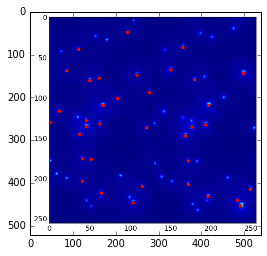

In [363]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

fname = '86XgT.png'
neighborhood_size = 5
threshold = 1500

data = scipy.misc.imread(fname)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

plt.imshow(data)
plt.savefig('data.png', bbox_inches = 'tight')

plt.autoscale(False)
plt.plot(xy[:, 1], xy[:, 0], 'ro')
plt.savefig('result.png', bbox_inches = 'tight')